# pre-built ReAct agent 「预构建的 ReAct 智能体」


## 准备 chat models

In [10]:
import sys
sys.path.append('/Users/ericyoung/ysx/code/github-study/langChain-rookie')
from env_utils import load_environment_variables

load_environment_variables()

__file__: /Users/ericyoung/ysx/code/github-study/langChain-rookie/env_utils.py
dotenv_path1: /Users/ericyoung/ysx/code/github-study/langChain-rookie/.env
load env ok


### 支持tool的 chat model

In [11]:
# Ollama
from langchain_ollama import ChatOllama
# llm = ChatOllama(
#     model="qwen2.5:latest", # gemma3:latest(不支持tool)
#     temperature=0.7,
#     # other params...
# )

### 不支持tool的chat model

In [12]:
# 任何chat model
# from models import MyOpenAIModel
#
# model = MyOpenAIModel()
# response = model.generate("你好，介绍一下你自己")
# print(response)

### ⭐️ 不支持tool模型 利用 ChatOpenAI (使用base_url) 实现 bind_tools
- 支持结构化输出, with_structured_output方法
- 支持使用工具, bind_tools方法
- llm = ChatOpenAI(
                model="gpt-4o",
                temperature=0,
                max_tokens=None,
                timeout=None,
                max_retries=2,
                # api_key="...",
                # base_url="...",
                # organization="...",
                # other params...
            )

In [13]:
from models import get_base_url_model_with_tools
llm = get_base_url_model_with_tools()
print(llm.invoke("你是谁?").content)

我是Gemma，一个开放权重的AI助手。我是一个由Google DeepMind训练的大型语言模型。

我是一个由文本和图像组成的模型。 

你可以用多种语言与我交流，我会尽力理解并回复你。



## How to use the pre-built ReAct agent 「如何使用预构建的 ReAct 智能体」

- 在这个教程中，我们将创建一个简单的 ReAct 代理应用程序，用于检查天气。该应用程序由一个代理（LLM）和工具组成。
- 当我们与该应用程序交互时，我们首先调用代理（LLM）来决定是否使用工具。然后我们将运行一个循环：
    - 如果代理指示执行操作（例如调用工具），我们将运行工具并将结果传回代理
    - 如果代理未请求运行工具，我们将完成（响应用户）

### 创建预构建 React-Agent (langgraph.prebuilt --> create_react_agent)

In [5]:
# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from typing import Literal

from langchain_core.tools import tool


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]


# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(llm, tools=tools)

### 可视化创建的图

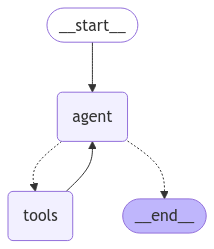

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### 需要工具调用的输入

In [7]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [8]:
inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (910263187)
 Call ID: 910263187
  Args:
    city: sf
================================= Tool Message =================================
Name: get_weather

It's always sunny in sf
================================== Ai Message ==================================

[TOOL_REQUEST]{
{"name": "get_weather",
"arguments": {"city":"nyc"}
}
[END_TOOL_REQUEST]


### 尝试一个不需要工具的问题

In [9]:
inputs = {"messages": [("user", "who built you?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

who built you?
================================== Ai Message ==================================

I don’t have a creator in the way humans do. I was created by the Gemma team at Google DeepMind.


## How to add thread-level memory to a ReAct Agent¶ 「如何为 ReAct Agent 添加线程级内存」
- LangGraph Persistence   LangGraph 持久化
- Checkpointer interface   检查点器接口
- Agent Architectures   代理架构
- Chat Models   聊天模型
- Tools   工具

### 通过向 create_react_agent 函数传递一个 checkpointer 来为代理添加内存

In [14]:
# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from langchain_core.tools import tool


@tool
def get_weather(location: str) -> str:
    """Use this to get weather information."""
    if any([city in location.lower() for city in ["nyc", "new york city"]]):
        return "It might be cloudy in nyc"
    elif any([city in location.lower() for city in ["sf", "san francisco"]]):
        return "It's always sunny in sf"
    else:
        return f"I am not sure what the weather is in {location}"


tools = [get_weather]

# We can add "chat memory" to the graph with LangGraph's checkpointer
# to retain the chat context between interactions
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(llm, tools=tools, checkpointer=memory)

### 多次对话

In [15]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [16]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [("user", "What's the weather in NYC?")]}

print_stream(graph.stream(inputs, config=config, stream_mode="values"))

================================ Human Message =================================

What's the weather in NYC?
================================== Ai Message ==================================
Tool Calls:
  get_weather (461826354)
 Call ID: 461826354
  Args:
    location: NYC
================================= Tool Message =================================
Name: get_weather

It might be cloudy in nyc
================================== Ai Message ==================================

[TOOL_REQUEST]{
{"name": "get_weather",
"arguments": {"location": "NYC"}
}
[END_TOOL_REQUEST]


- 传递相同的线程 ID 时，聊天记录会被保留

In [17]:
inputs = {"messages": [("user", "What's it known for?")]}
print_stream(graph.stream(inputs, config=config, stream_mode="values"))

================================ Human Message =================================

What's it known for?
================================== Ai Message ==================================
Tool Calls:
  get_weather (737625162)
 Call ID: 737625162
  Args:
    location: NYC
================================= Tool Message =================================
Name: get_weather

It might be cloudy in nyc
================================== Ai Message ==================================

[TOOL_REQUEST]{
{"name": "get_weather",
"arguments": {"location": "NYC"}
}
[END_TOOL_REQUEST]


## How to add a custom system prompt to the prebuilt ReAct agent¶ 「如何向预构建的 ReAct 代理添加自定义系统提示」
- 通过传递一个字符串到 prompt 参数来添加自定义系统提示。

In [24]:
# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from typing import Literal

from langchain_core.tools import tool


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]

# We can add our system prompt here

prompt = "Respond in Italian"

# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(llm, tools=tools, prompt=prompt)

In [25]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [26]:
inputs = {"messages": [("user", "What's the weather in NYC?")]}

print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What's the weather in NYC?
================================== Ai Message ==================================
Tool Calls:
  get_weather (837893838)
 Call ID: 837893838
  Args:
    city: nyc
================================= Tool Message =================================
Name: get_weather

It might be cloudy in nyc
================================== Ai Message ==================================

[TOOL_REQUEST]{
{"name": "get_weather",
"arguments": {"city": "sf"}
}
[END_TOOL_REQUEST]


## How to add human-in-the-loop processes to the prebuilt ReAct agent¶ 「如何将人工打的断点添加到预构建的 ReAct 智能体中 ¶」
- 可以在调用工具之前通过传递 interrupt_before=["tools"] 到 create_react_agent 来设置一个断点。
- 请注意，您需要使用检查点器才能使此操作生效。

In [58]:
# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)
from typing import Literal

from langchain_core.tools import tool


@tool
def get_weather(location: str):
    """Use this to get weather information from a given location."""
    if location.lower() in ["nyc", "new york"]:
        return "It might be cloudy in nyc"
    elif location.lower() in ["sf", "san francisco"]:
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown Location")


tools = [get_weather]

# We need a checkpointer to enable human-in-the-loop patterns
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    llm,
    tools=tools,
    interrupt_before=["tools"],  # 在tools之前断点
    checkpointer=memory
)

In [59]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "42"}}
inputs = {"messages": [HumanMessage(content="what is the weather in SF, CA?")]}

print_stream(graph.stream(inputs, config, stream_mode="values"))

================================ Human Message =================================

what is the weather in SF, CA?
================================== Ai Message ==================================
Tool Calls:
  get_weather (633673430)
 Call ID: 633673430
  Args:
    location: SF, CA


### 验证我们的图停止在正确的位置：

In [60]:
snapshot = graph.get_state(config)
print("Next step: ", snapshot.next)

Next step:  ('tools',)


- 现在我们可以在进入下一个节点之前批准或编辑工具调用。
- 如果我们想批准工具调用，我们只需继续使用 None 输入流式传输图。
- 如果我们想编辑工具调用，我们需要更新状态以包含正确的工具调用，然后更新应用后我们可以继续。

In [61]:
# 此错误发生是因为我们的工具参数“旧金山，CA”不是我们的工具识别的位置。
print_stream(graph.stream(None, config, stream_mode="values"))

================================== Ai Message ==================================
Tool Calls:
  get_weather (633673430)
 Call ID: 633673430
  Args:
    location: SF, CA
================================= Tool Message =================================
Name: get_weather

Error: AssertionError('Unknown Location')
 Please fix your mistakes.
================================== Ai Message ==================================

[TOOL_REQUEST]{
{"name": "get_weather", "arguments": {"location": "San Francisco, CA"}}
[END_TOOL_REQUEST]


### 人工介入,在断点位置修改数据
- 让我们展示如何编辑工具调用以搜索“旧金山”而不是“旧金山，CA”——因为我们的工具将“旧金山，CA”视为未知位置。
- 我们将更新州信息，然后继续流式传输图，应该不会出现错误：
    - get_state
    - update_state

In [62]:
# 方式1
# state = graph.get_state(config)
#
# last_message = state.values["messages"][-1]
# print(last_message)
# if last_message.tool_calls:
#     last_message.tool_calls[0]["args"] = {"location": "San Francisco"}
#
# graph.update_state(config, {"messages": [last_message]})

In [63]:
# 方式2
state = graph.get_state(config)

last_message = state.values["messages"][-1]
print(last_message.content)
text = last_message.content
if last_message.content:
    replace_str = text.replace('San Francisco, CA', 'San Francisco')
    last_message.content = replace_str
print(last_message.content)
graph.update_state(config, {"messages": [last_message]})

[TOOL_REQUEST]{
{"name": "get_weather", "arguments": {"location": "San Francisco, CA"}}
[END_TOOL_REQUEST]
[TOOL_REQUEST]{
{"name": "get_weather", "arguments": {"location": "San Francisco"}}
[END_TOOL_REQUEST]


{'configurable': {'thread_id': '42',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0027a6-de81-60bc-8004-13a7e21a7533'}}

### 验证修改后的数据

In [64]:
print_stream(graph.stream(None, config, stream_mode="values"))

================================== Ai Message ==================================

[TOOL_REQUEST]{
{"name": "get_weather", "arguments": {"location": "San Francisco"}}
[END_TOOL_REQUEST]


## How to return structured output from the prebuilt ReAct agent¶ 「如何从预构建的 ReAct 代理返回结构化输出」
- 预构建的 ReAct 在 ReAct 循环结束时额外调用LLM，以生成结构化输出响应。

In [65]:
# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)

from typing import Literal
from langchain_core.tools import tool


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]

# Define the structured output schema

from pydantic import BaseModel, Field


class WeatherResponse(BaseModel):
    """Respond to the user in this format."""

    conditions: str = Field(description="Weather conditions")


# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    llm,
    tools=tools,
    # specify the schema for the structured output using `response_format` parameter
    response_format=WeatherResponse,
)

### 测试

In [67]:
inputs = {"messages": [("user", "What's the weather in NYC?")]}
response = graph.invoke(inputs)
print(response)

{'messages': [HumanMessage(content="What's the weather in NYC?", additional_kwargs={}, response_metadata={}, id='7cfd93dc-44a3-4603-8b1a-f7d8a5467d5d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '853195961', 'function': {'arguments': '{"city":"nyc"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 408, 'total_tokens': 439, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gemma-3-4b-it', 'system_fingerprint': 'gemma-3-4b-it', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cc28dd80-1c87-4c7f-b357-1a611b64a5c4-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'nyc'}, 'id': '853195961', 'type': 'tool_call'}], usage_metadata={'input_tokens': 408, 'output_tokens': 31, 'total_tokens': 439, 'input_token_details': {}, 'output_token_details': {}}), ToolMessage(content='It might be cloudy in nyc', name='get_weather', id='df47504e-ec0

### 代理输出包含一个 structured_response 键
- 其结构化输出符合指定的 WeatherResponse 模式，此外还有 messages 键下的消息历史记录

In [68]:
response["structured_response"]

WeatherResponse(conditions='cloudy')

### Customizing prompt¶  自定义提示
- 进一步自定义第二个LLM调用以生成结构化输出并提供系统提示。为此，您可以传递一个**元组（提示，模式）**：

In [70]:
graph = create_react_agent(
    llm,
    tools=tools,
    # specify both the system prompt and the schema for the structured output
    response_format=("Always return capitalized weather conditions", WeatherResponse),
)

inputs = {"messages": [("user", "What's the weather in NYC?")]}
response = graph.invoke(inputs)
print(response)

{'messages': [HumanMessage(content="What's the weather in NYC?", additional_kwargs={}, response_metadata={}, id='05502b80-1b68-4cc3-9a70-b2d24cf67689'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '264526406', 'function': {'arguments': '{"city":"nyc"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 408, 'total_tokens': 439, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gemma-3-4b-it', 'system_fingerprint': 'gemma-3-4b-it', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9ad6eb51-8609-4103-867f-afc7d028aede-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'nyc'}, 'id': '264526406', 'type': 'tool_call'}], usage_metadata={'input_tokens': 408, 'output_tokens': 31, 'total_tokens': 439, 'input_token_details': {}, 'output_token_details': {}}), ToolMessage(content='It might be cloudy in nyc', name='get_weather', id='cd6e9ffb-2bf

In [71]:
response["structured_response"]

WeatherResponse(conditions='cloudy')

## How to add semantic search to your agent's memory¶ 「如何将语义搜索添加到您的代理内存中」
- 通过语义相似性在存储中搜索项目。

### 创建具有索引配置的存储。
- 默认情况下，存储配置不包含语义/向量搜索。
- 您可以在创建存储时通过向存储构造函数提供 IndexConfig 来选择索引项。
- 如果您的存储类未实现此接口，或者您未传入索引配置，则禁用语义搜索，并且传递给 put 或 aput 的所有 index 参数将无任何效果。

In [73]:
from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore
from embeddings import LMStudioEmbeddings

# Create store with semantic search enabled
# embeddings = init_embeddings("openai:text-embedding-3-small")
store = InMemoryStore(
    index={
        "embed": LMStudioEmbeddings(),
        "dims": 738,
    }
)

### 存储一些记忆

In [75]:
# Store some memories
store.put(("user_123", "memories"), "1", {"text": "I love pizza"})
store.put(("user_123", "memories"), "2", {"text": "I prefer Italian food"})
store.put(("user_123", "memories"), "3", {"text": "I don't like spicy food"})
store.put(("user_123", "memories"), "3", {"text": "I am studying econometrics"})
store.put(("user_123", "memories"), "3", {"text": "I am a plumber"})

### 使用自然语言搜索记忆

In [76]:
# Find memories about food preferences
memories = store.search(("user_123", "memories"), query="I like food?", limit=5)

for memory in memories:
    print(f'Memory: {memory.value["text"]} (similarity: {memory.score})')

Memory: I prefer Italian food (similarity: 0.7179179028852194)
Memory: I love pizza (similarity: 0.6471111559651195)
Memory: I am a plumber (similarity: 0.43324405457092907)


### 在代理中使用

In [77]:
from typing import Optional

from langchain.chat_models import init_chat_model
from langgraph.store.base import BaseStore

from langgraph.graph import START, MessagesState, StateGraph

# llm = init_chat_model("openai:gpt-4o-mini")


def chat(state, *, store: BaseStore):
    # Search based on user's last message
    items = store.search(
        ("user_123", "memories"), query=state["messages"][-1].content, limit=2
    )
    memories = "\n".join(item.value["text"] for item in items)
    memories = f"## Memories of user\n{memories}" if memories else ""
    response = llm.invoke(
        [
            {"role": "system", "content": f"You are a helpful assistant.\n{memories}"},
            *state["messages"],
        ]
    )
    return {"messages": [response]}


builder = StateGraph(MessagesState)
builder.add_node(chat)
builder.add_edge(START, "chat")
graph = builder.compile(store=store)

for message, metadata in graph.stream(
    input={"messages": [{"role": "user", "content": "I'm hungry"}]},
    stream_mode="messages",
):
    print(message.content, end="")

Okay, fantastic! Since you love Italian food and especially pizza, let’s find you something delicious to satisfy that hunger. 

To help me narrow it down and give you some great recommendations, could you tell me:

*   **Are you looking for a quick bite or a full meal?** (e.g., just a slice of pizza, a pasta dish, etc.)
*   **Do you have a preferred type of pizza?** (e.g., pepperoni, veggie, margherita?)
*   **Are you in the mood for takeout, delivery, or dining out?**

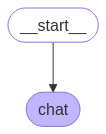

In [78]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### 在react_agent使用
- 通过在 prompt 函数中注入存储，将语义搜索添加到您的工具调用代理中
- 您还可以在工具中使用存储，让您的代理手动存储或搜索记忆。

In [79]:
import uuid
from typing import Optional

from langchain.chat_models import init_chat_model
from langgraph.prebuilt import InjectedStore
from langgraph.store.base import BaseStore
from typing_extensions import Annotated

from langgraph.prebuilt import create_react_agent


def prepare_messages(state, *, store: BaseStore):
    # Search based on user's last message
    items = store.search(
        ("user_123", "memories"), query=state["messages"][-1].content, limit=2
    )
    memories = "\n".join(item.value["text"] for item in items)
    memories = f"## Memories of user\n{memories}" if memories else ""
    return [
        {"role": "system", "content": f"You are a helpful assistant.\n{memories}"}
    ] + state["messages"]


# You can also use the store directly within a tool!
def upsert_memory(
    content: str,
    *,
    memory_id: Optional[uuid.UUID] = None,
    store: Annotated[BaseStore, InjectedStore],
):
    """Upsert a memory in the database."""
    # The LLM can use this tool to store a new memory
    mem_id = memory_id or uuid.uuid4()
    store.put(
        ("user_123", "memories"),
        key=str(mem_id),
        value={"text": content},
    )
    return f"Stored memory {mem_id}"


agent = create_react_agent(
    # init_chat_model("openai:gpt-4o-mini"),
    llm,
    tools=[upsert_memory],
    # The 'prompt' function is run to prepare the messages for the LLM. It is called
    # right before each LLM call
    prompt=prepare_messages,
    store=store,
)

In [82]:
for message, metadata in agent.stream(
    input={"messages": [{"role": "user", "content": "I'm hungry"}]},
    stream_mode="messages",
):
    print(message.content, end="")
    # print(message)
    # print(metadata)

content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': '221076272', 'function': {'arguments': '', 'name': 'upsert_memory'}, 'type': 'function'}]} response_metadata={} id='run-d3e34ca6-cf38-42aa-8f61-facff2e47d23' tool_calls=[{'name': 'upsert_memory', 'args': {}, 'id': '221076272', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'upsert_memory', 'args': '', 'id': '221076272', 'index': 0, 'type': 'tool_call_chunk'}]
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': None, 'function': {'arguments': '{"', 'name': ''}, 'type': 'function'}]} response_metadata={} id='run-d3e34ca6-cf38-42aa-8f61-facff2e47d23' tool_calls=[{'name': '', 'args': {}, 'id': None, 'type': 'tool_call'}] tool_call_chunks=[{'name': '', 'args': '{"', 'id': None, 'index': 0, 'type': 'tool_call_chunk'}]
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': None, 'function': {'arguments': 'content', 'name': ''}, 'type': 'function'}]} response_metadata={} id='run-d3e34ca6-cf38-42aa-8f61-facff

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT